In [1]:
import numpy as np
import matplotlib.pyplot as plt
import function as func
import os
import lmfit
import math
from scipy import integrate

In [8]:
arr1 = np.arange(2,302,50)   # rough mesh
arr2 = np.arange(302,512,10) # fine mesh
arr3 = np.arange(552,802,50) # rough mesh
x = np.hstack([arr1, arr2, arr3])
y = np.hstack([arr1, arr2, arr3])

#y = np.array([412])
#x = np.arange(5, 805, 50)
                                                     
x_grid, y_grid = np.meshgrid(x, y) # 2D grid in x-axis / y-axis                                                       
xx = x_grid.reshape(-1) # flatten to 1D array                                                                         
yy = y_grid.reshape(-1) # flatten to 1D array                                                                         
xy_list = np.stack((xx, yy), axis=1) # create list of (x,y) 

In [3]:
fit_result = {
    "18": {}, 
    "19": {}, 
    "20": {}, 
    "21": {}, 
    "22": {}, 
    "23": {}, 
    "24": {}, 
    "25": {}, 
    "26": {}
}

In [4]:
def fit_func(x, y, height, mean_x, mean_y, sigma):
    return height * np.exp( - np.power((x-mean_x)/sigma, 2.)/2) * np.exp( - np.power((y-mean_y)/sigma, 2.)/2)

def residual(params, x, y, z, ze):
    height = params['height']
    mean_x = params['mean_x']
    mean_y = params['mean_y']
    sigma = params['sigma']

    y_model = fit_func(x, y, height, mean_x, mean_y, sigma)

    chi = (z - y_model)/ze
    o = np.isfinite(chi)
    return chi[o]

def fit_3D(x, y, z, ze):
    params = lmfit.Parameters()

    params.add('height', value=1.5e-5)
    params.add('mean_x', value=400.)
    params.add('mean_y', value=400.)
    params.add('sigma', value=100.)
    
    result = lmfit.minimize(residual, params, args=(x, y, z, ze))

    h = result.params["height"].value
    he = result.params["height"].stderr
    mx = result.params["mean_x"].value
    my = result.params["mean_y"].value
    mxe = result.params["mean_x"].stderr
    mye = result.params["mean_y"].stderr
    s = np.abs(result.params["sigma"].value)
    se = result.params["sigma"].stderr
    
    print(f"height     : {h}")
    print(f"height_err : {he}")
    print(f"mean  x    : {mx}")
    print(f"sigma x    : {mxe}")
    print(f"mean  y    : {my}")
    print(f"sigma y    : {mye}")
    print(f"sigma      : {s}")
    print(f"sigma_err  : {se}")
    print(f"HPBW : {2*np.sqrt(2*np.log(2))*np.degrees(np.arctan(s/1085))}")
    print(f"HPBW : {2*np.sqrt(2*2*np.log(2))*np.degrees(np.arctan(s/1085))}")
    
    #z = fit_func(x, y, h, mx, my, s)
    #ax.errorbar(x, y, z, zerr = 0, fmt="x", markersize=5, color="r", label="fit result")
    
    return h, mx, my, mxe, mye, s, se

In [5]:
def get_power(freq, p, xy_list):
    x = np.zeros(len(xy_list))
    y = np.zeros(len(xy_list))
    z = np.zeros(len(xy_list))
    ze = np.zeros(len(xy_list))
    
    x_cen = np.zeros(0) # points of y where x is center
    y_cen = np.zeros(0) # points of x where y is center
    zx = np.zeros(0)
    zy = np.zeros(0)
    zxe = np.zeros(0)
    zye = np.zeros(0)

    for i, xy in enumerate(xy_list):
        _x = xy[0]
        _y = xy[1]
        path = p + "{}GHz/{}_{}_{}_ON1.dat".format(freq, i, _x, _y)
        ON1 = np.max(func.dat_to_array(path)[1])
        path = p + "{}GHz/{}_{}_{}_ON2.dat".format(freq, i, _x, _y)
        ON2 = np.max(func.dat_to_array(path)[1])
        path = p + "{}GHz/{}_{}_{}_OFF1.dat".format(freq, i, _x, _y)
        OFF1 = np.max(func.dat_to_array(path)[1])
        path = p + "{}GHz/{}_{}_{}_OFF2.dat".format(freq, i, _x, _y)
        OFF2 = np.max(func.dat_to_array(path)[1])

        x[i] = _x
        y[i] = _y
        z[i] = np.mean(np.array([ON1-OFF1, ON2-OFF2]))
        ze[i] = np.std(np.array([ON1-OFF1, ON2-OFF2]))
             
    return x, y, z, ze

In [9]:
freq = 19
out_path = "/data/xy_scan/2022-02-18_cycle_"
x, y, z, ze = get_power(freq, out_path, xy_list)

FileNotFoundError: [Errno 2] No such file or directory: '/data/xy_scan/2022-02-18_cycle_19GHz/0_2_2_ON1.dat'

NameError: name 'z' is not defined

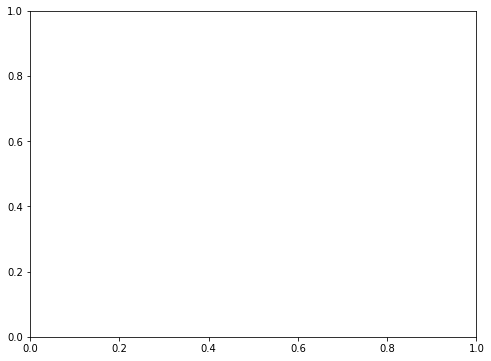

In [6]:
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

mappable = ax.scatter(x, y, c=z, vmin=0, vmax=3e-5, s=30, cmap=cm)
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_title("{} GHz".format(freq))
 
fig.colorbar(mappable, ax=ax)

#plt.savefig("../result_figure/xy_scan/colormap_{}GHz.pdf".format(freq))

In [322]:
h, mx, my, mxe, mye, s, se = fit_3D(x, y, z, ze)
fit_result[str(freq)]["h"] = h
fit_result[str(freq)]["mx"] = mx
fit_result[str(freq)]["my"] = my
fit_result[str(freq)]["mxe"] = mxe
fit_result[str(freq)]["mye"] = mye
fit_result[str(freq)]["s"] = s
fit_result[str(freq)]["se"] = se

height     : 2.1062597339817244e-05
height_err : 2.6489723876918377e-07
mean  x    : 398.5958472897014
sigma x    : 1.2116824960903587
mean  y    : 423.4125136205084
sigma y    : 0.7606479776373473
sigma      : 93.83192302847472
sigma_err  : 0.29929021200163414
HPBW : 11.639170668670173


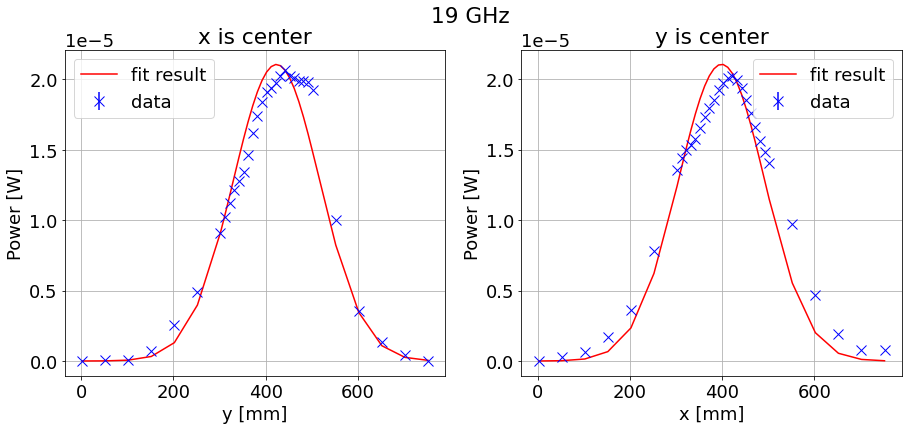

In [324]:
def gauss_1d(x, h, m, s):
    return h * np.exp(- (x-m)**2 / (2 * s**2))

x_cen = np.zeros(0) # points of y where x is center
y_cen = np.zeros(0) # points of x where y is center
zx = np.zeros(0)
zy = np.zeros(0)
zxe = np.zeros(0)
zye = np.zeros(0)

for xx, yy, zz, zee, in zip(x, y, z, ze):
    # x is center
    if xx == 402:
        x_cen = np.append(x_cen, yy)
        zx = np.append(zx, zz)
        zxe = np.append(zxe, zee)
    # y is center
    if yy == 422:
        y_cen = np.append(y_cen, xx)
        zy = np.append(zy, zz)
        zye = np.append(zye, zee)
        
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(1,2,figsize=(15,6), squeeze=False)
fig.suptitle("{} GHz".format(freq))

# x is center
ax = axes[0][0]
ax.errorbar(x_cen, zx, yerr = zxe, capsize=0, fmt='x', markersize=10, 
            ecolor='blue', markeredgecolor = "blue", color='blue', label="data")
ax.plot(x_cen, gauss_1d(x_cen, fit_result[str(freq)]["h"], fit_result[str(freq)]["my"], fit_result[str(freq)]["s"]), 
        color="red", label="fit result")
ax.set_xlabel("y [mm]")
ax.set_ylabel("Power [W]")
ax.set_title("x is center")
ax.grid()
ax.legend()

# y is center
ax = axes[0][1]
ax.errorbar(y_cen, zy, yerr = zye, capsize=0, fmt='x', markersize=10, 
            ecolor='blue', markeredgecolor = "blue", color='blue', label="data")
ax.plot(x_cen, gauss_1d(x_cen, fit_result[str(freq)]["h"], fit_result[str(freq)]["mx"], fit_result[str(freq)]["s"]), 
        color="red", label="fit result")
ax.set_xlabel("x [mm]")
ax.set_ylabel("Power [W]")
ax.set_title("y is center")
ax.grid()
ax.legend()

#plt.savefig("../result_figure/xy_scan/center_{}GHz.pdf".format(freq))

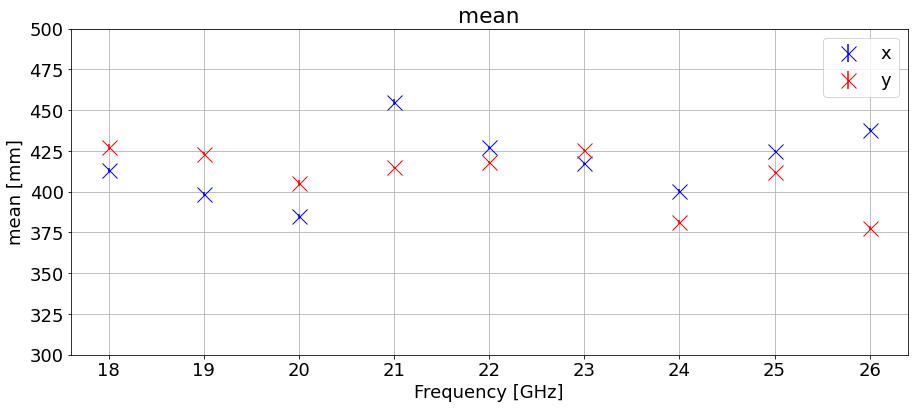

In [297]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

for i in range(18, 27, 1):
    plt.errorbar(i, fit_result[str(i)]["mx"], yerr=fit_result[str(i)]["mxe"], markersize=15, fmt="x", capsize=0, color="blue")
    plt.errorbar(i, fit_result[str(i)]["my"], yerr=fit_result[str(i)]["mye"], markersize=15, fmt="x", capsize=0, color="red")

plt.errorbar(20, 0, yerr=0, markersize=15, fmt="x", capsize=0, color="blue", label="x")
plt.errorbar(20, 0, yerr=0, markersize=15, fmt="x", capsize=0, color="red", label="y")
plt.ylim([300, 500])
plt.grid()
plt.legend()
plt.title("mean")
plt.ylabel("mean [mm]")
plt.xlabel("Frequency [GHz]")
plt.savefig("../result_figure/xy_scan/mean.pdf")

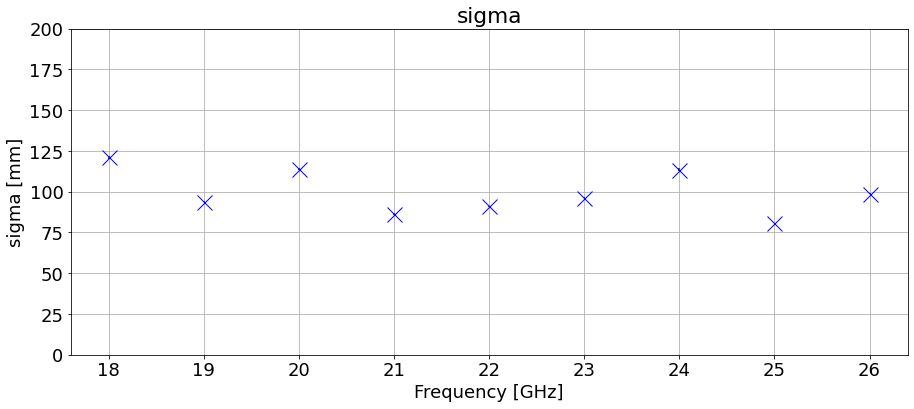

In [300]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

for i in range(18, 27, 1):
    plt.errorbar(i, fit_result[str(i)]["s"], yerr=fit_result[str(i)]["se"], markersize=15, fmt="x", capsize=0, color="blue")

plt.ylim([0, 200])
plt.grid()
plt.title("sigma")
plt.ylabel("sigma [mm]")
plt.xlabel("Frequency [GHz]")
plt.savefig("../result_figure/xy_scan/sigma.pdf")

In [10]:
y = np.array([412])
x = np.arange(5, 765, 10)
                                                     
x_grid, y_grid = np.meshgrid(x, y) # 2D grid in x-axis / y-axis                                                       
xx = x_grid.reshape(-1) # flatten to 1D array                                                                         
yy = y_grid.reshape(-1) # flatten to 1D array                                                                         
xy_list = np.stack((xx, yy), axis=1) # create list of (x,y) 

In [11]:
def get_power_test(freq, p, xy_list):
    x = np.zeros(len(xy_list))
    y = np.zeros(len(xy_list))
    z = np.zeros(len(xy_list))
    ze = np.zeros(len(xy_list))
    
    x_cen = np.zeros(0) # points of y where x is center
    y_cen = np.zeros(0) # points of x where y is center
    zx = np.zeros(0)
    zy = np.zeros(0)
    zxe = np.zeros(0)
    zye = np.zeros(0)

    for i, xy in enumerate(xy_list):
        _x = xy[0]
        _y = xy[1]
        path = p + "{}_{}_{}_ON1.dat".format(i, _x, _y)
        ON1 = np.max(func.dat_to_array(path)[1])
        path = p + "{}_{}_{}_ON2.dat".format(i, _x, _y)
        ON2 = np.max(func.dat_to_array(path)[1])
        path = p + "{}_{}_{}_OFF1.dat".format(i, _x, _y)
        OFF1 = np.max(func.dat_to_array(path)[1])
        path = p + "{}_{}_{}_OFF2.dat".format(i, _x, _y)
        OFF2 = np.max(func.dat_to_array(path)[1])

        x[i] = _x
        y[i] = _y
        z[i] = np.mean(np.array([ON1-OFF1, ON2-OFF2]))
        ze[i] = np.std(np.array([ON1-OFF1, ON2-OFF2]))
             
    return x, y, z, ze

In [12]:
def gause_model(x, mean, sigma, height):
    return height * np.exp( -1./2. * ((x-mean)/sigma) ** 2.)

def gause_residual(params, x, y, yerr):
    mean = params['mean']
    sigma = params['sigma']
    height = params['height']
    y_model = gause_model(x, mean, sigma, height)
    chi = (y - y_model)/yerr
    a = np.isfinite(chi)
    return chi[a]

def num(text):
    if text == 0: return "1st"
    if text == 1: return "2nd"
    if text == 2: return "3rd"
    if text == 3: return "4th"
    if text == 4: return "5th"

In [15]:
def plot_power(ax, freq):
    for i in range(3):
        out_path = "/data/xy_scan/2022-03-08_cycle/{}GHz_{}_Y/".format(freq,i)
        x, y, z, ze = get_power_test(freq, out_path, xy_list)

        ax.plot(x, z, label=num(i))
        #ax.scatter(y, z, label=num(i), marker="x", s=200)

    ax.set_xlabel("Position [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("{} GHz".format(freq))
    ax.set_ylim([-0.2e-5, 2.7e-5])
    ax.grid()
    ax.legend(loc="upper left")
    
def plot_fit(ax, freq):
    num = 3
    x = np.zeros(len(xy_list))
    y = np.zeros(len(xy_list))
    z = np.zeros(len(xy_list))
    ze = np.zeros(len(xy_list))
    for i in range(num):
        out_path = "/data/xy_scan/2022-03-08_cycle/{}GHz_{}_Y/".format(freq,i)
        xx, yy, zz, zze = get_power_test(freq, out_path, xy_list)
        x += xx
        y += yy
        z += zz
        ze += zze
        
    hol = x/num
    ver = z/num
    ver_e = ze/num
        
    # data
    # ax.plot(hol, ver, color="blue")
    ax.scatter(hol, ver, label="mean of {}".format(num), s=2, color="blue")
    
    # fit
    params = lmfit.Parameters()
    params.add('mean', value=400.)
    params.add('sigma', value=100.)
    params.add('height', value=1.e-5)

    result = lmfit.minimize(gause_residual, params, args=(hol, ver, ver_e))
    height = result.params["height"].value
    mean = result.params["mean"].value
    mean_err = result.params["mean"].stderr
    sigma = result.params["sigma"].value
    sigma_err = result.params["sigma"].stderr
    ax.plot(hol, gause_model(hol, mean, sigma, height), label="fit result", color="r")
    ax.text(0.62, 0.85, r"$\sigma$ = " + str(round(sigma,1)) + r"$\pm$" + str(round(sigma_err,1)), transform=ax.transAxes)
    print(sigma)

    # setting
    ax.set_xlabel("Position [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("{} GHz".format(freq))
    ax.set_ylim([-0.2e-5, 2.7e-5])
    ax.grid()
    ax.legend(loc="upper left")

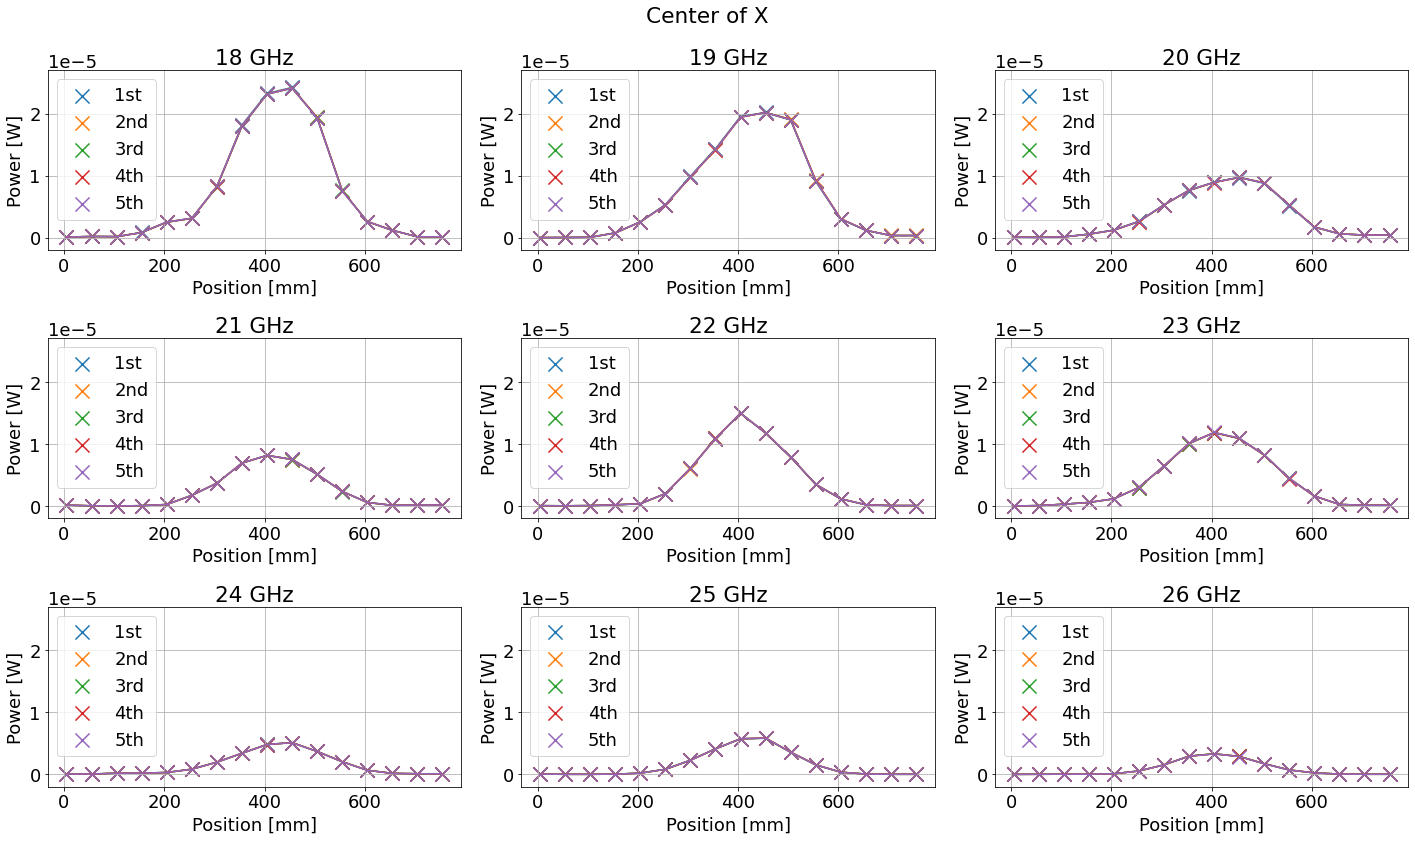

In [92]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle("Center of X")

plot_power(axes[0][0], "18")
plot_power(axes[0][1], "19")
plot_power(axes[0][2], "20")
plot_power(axes[1][0], "21")
plot_power(axes[1][1], "22")
plot_power(axes[1][2], "23")
plot_power(axes[2][0], "24")
plot_power(axes[2][1], "25")
plot_power(axes[2][2], "26")

fig.tight_layout()

#plt.savefig("../result_figure/xy_scan/5times_measure/power_X_center.pdf")

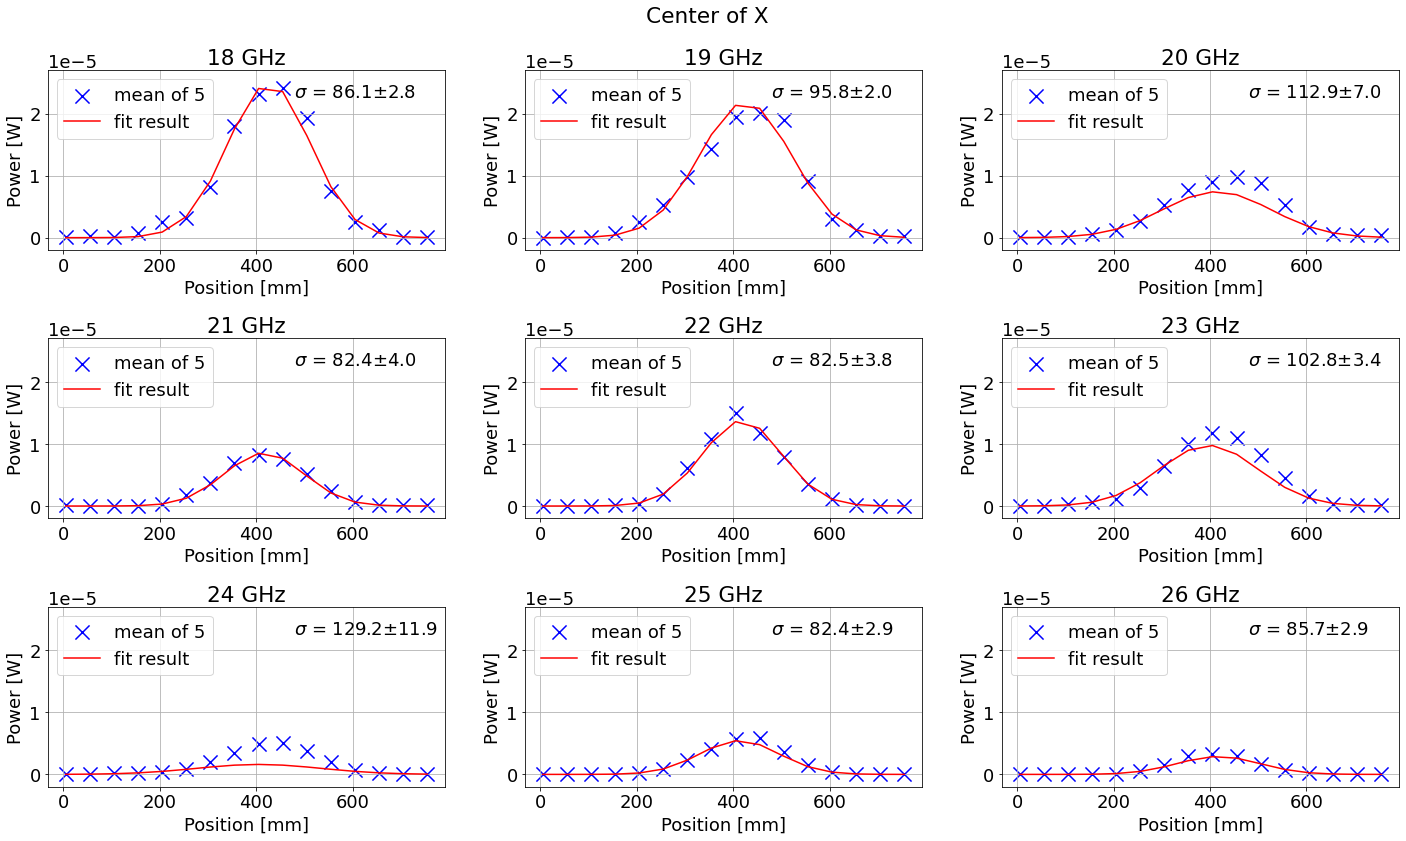

In [125]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle("Center of X")

plot_fit(axes[0][0], "18")
plot_fit(axes[0][1], "19")
plot_fit(axes[0][2], "20")
plot_fit(axes[1][0], "21")
plot_fit(axes[1][1], "22")
plot_fit(axes[1][2], "23")
plot_fit(axes[2][0], "24")
plot_fit(axes[2][1], "25")
plot_fit(axes[2][2], "26")

fig.tight_layout()

plt.savefig("../result_figure/xy_scan/5times_measure/power_X_center.pdf")

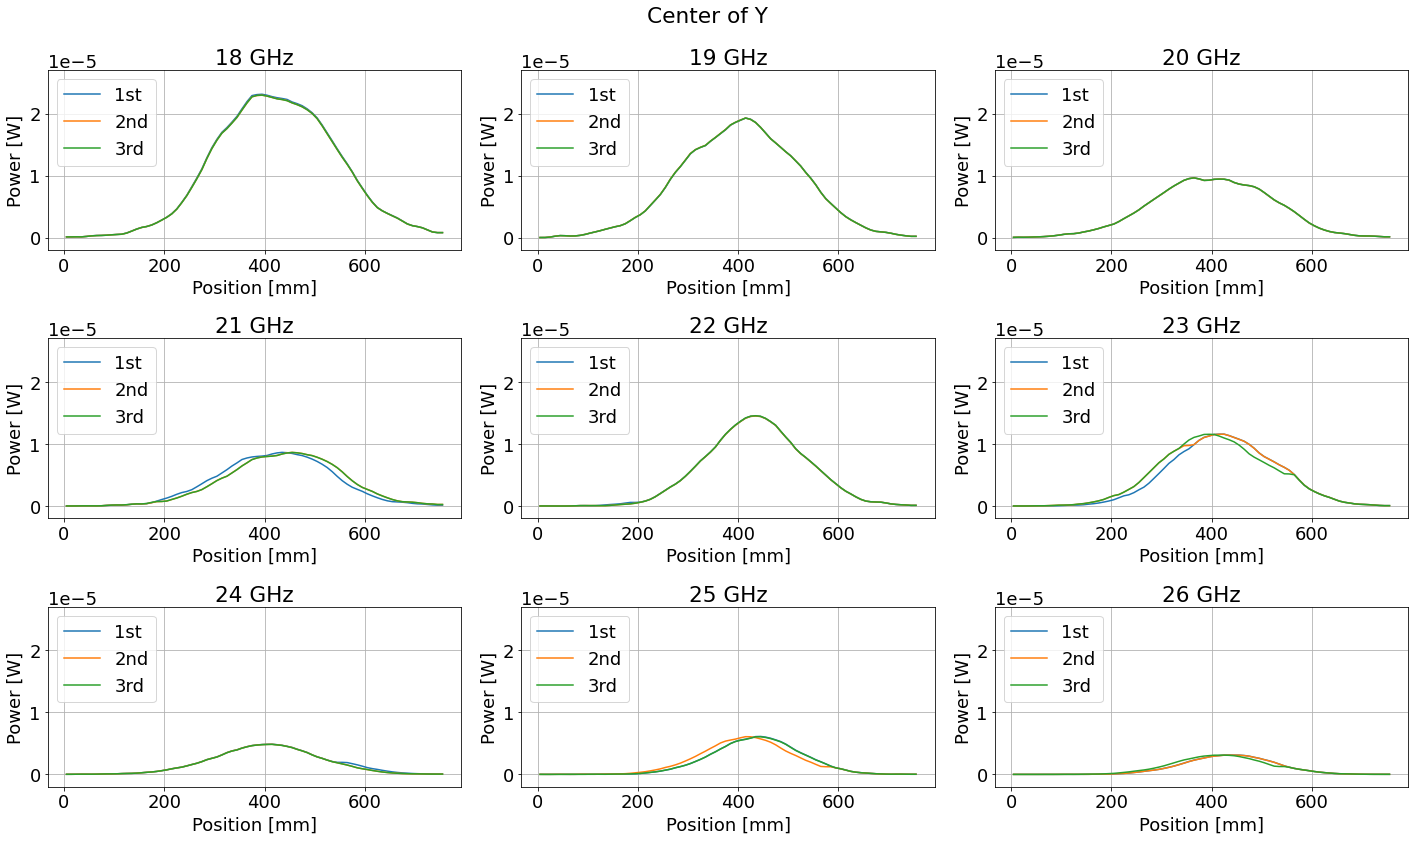

In [14]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle("Center of Y")

plot_power(axes[0][0], "18")
plot_power(axes[0][1], "19")
plot_power(axes[0][2], "20")
plot_power(axes[1][0], "21")
plot_power(axes[1][1], "22")
plot_power(axes[1][2], "23")
plot_power(axes[2][0], "24")
plot_power(axes[2][1], "25")
plot_power(axes[2][2], "26")

fig.tight_layout()

#plt.savefig("../result_figure/xy_scan/3times_measure/power_Y_center.pdf")

119.96881402527835
113.69627118412753
116.21611018120325
112.54293950557368
97.34826745249335
103.85482455589194
110.92629324485387
93.3352920039502
90.6886208444536


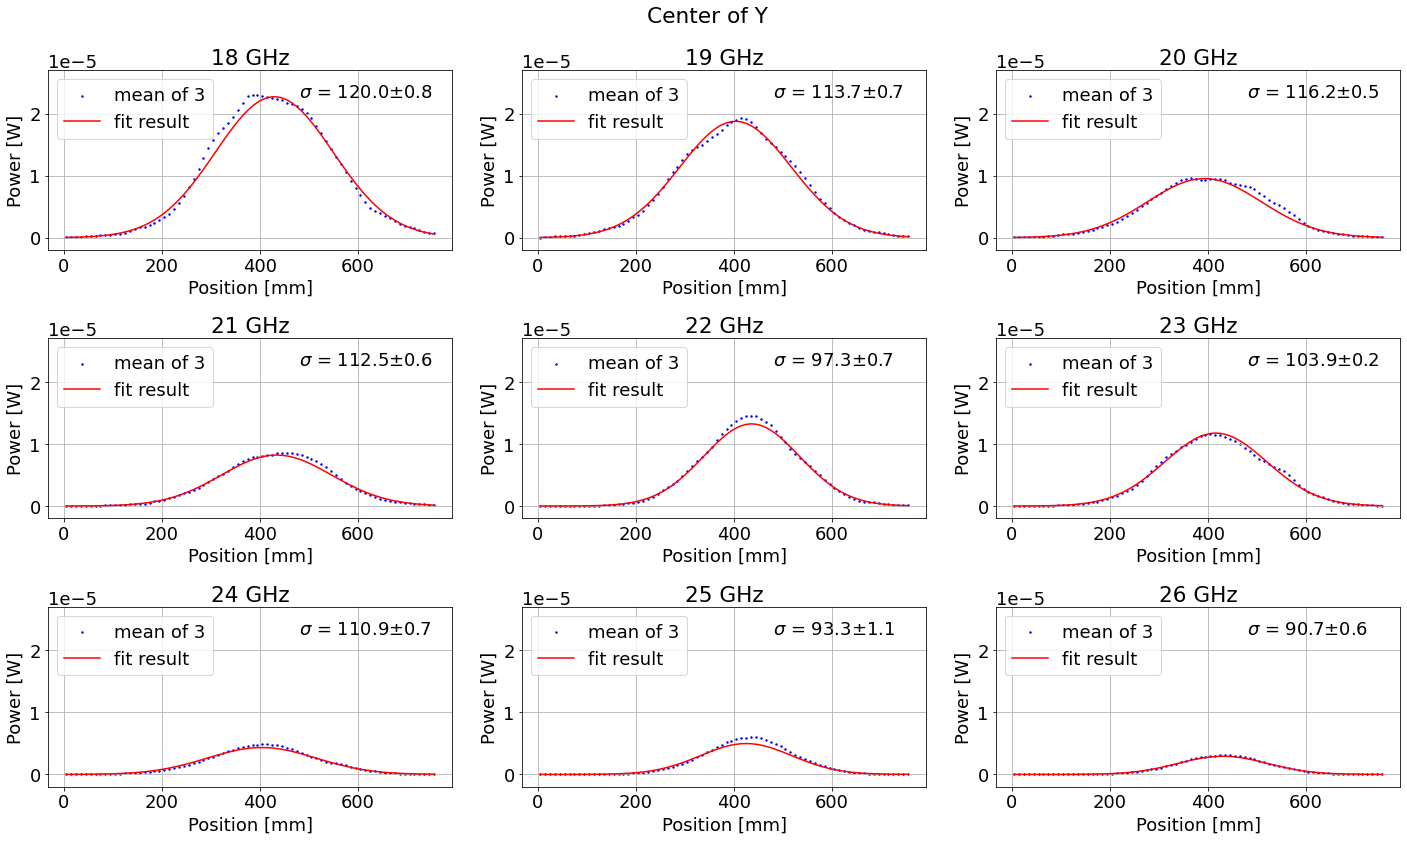

In [16]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle("Center of Y")

plot_fit(axes[0][0], "18")
plot_fit(axes[0][1], "19")
plot_fit(axes[0][2], "20")
plot_fit(axes[1][0], "21")
plot_fit(axes[1][1], "22")
plot_fit(axes[1][2], "23")
plot_fit(axes[2][0], "24")
plot_fit(axes[2][1], "25")
plot_fit(axes[2][2], "26")

fig.tight_layout()

#plt.savefig("../result_figure/xy_scan/3times_measure/fit_Y_center.pdf")

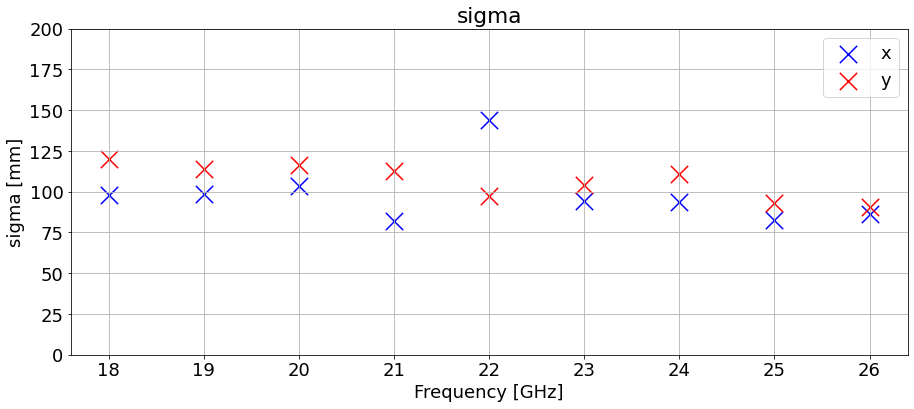

In [167]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

freq = np.array([18, 19, 20, 21, 22, 23, 24, 25, 26])
sigma_x = np.array([97.9, 98.7, 103.6, 82.2, 144.0, 94.4, 94.0, 82.4, 86.1])
sigma_y = np.array([120.0, 113.7, 116.2, 112.5, 97.3, 103.9, 110.9, 93.3, 90.7])

plt.scatter(freq, sigma_x, s=300, marker="x", color="blue", label="x")
plt.scatter(freq, sigma_y, s=300, marker="x", color="red", label="y")

plt.ylim([0, 200])
plt.grid()
plt.legend()
plt.title("sigma")
plt.ylabel("sigma [mm]")
plt.xlabel("Frequency [GHz]")
plt.savefig("../result_figure/xy_scan/3times_measure/sigma.pdf")

Text(0.5, 0, 'Frequency [GHz]')

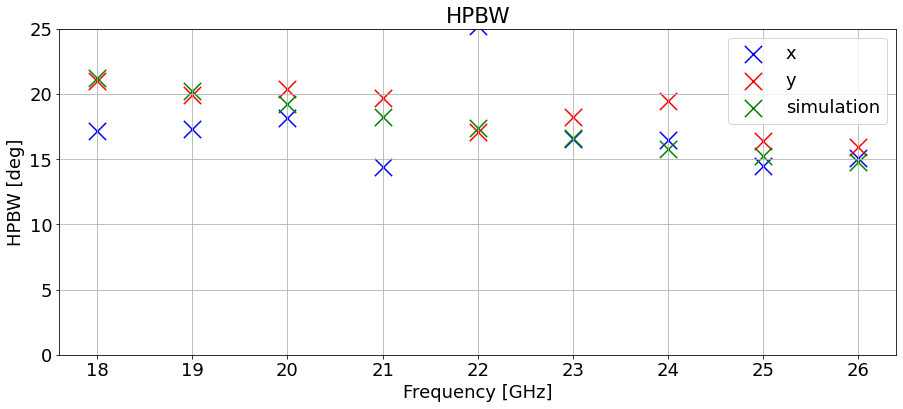

In [17]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

freq = np.array([18, 19, 20, 21, 22, 23, 24, 25, 26])
sigma_x = np.array([97.9, 98.7, 103.6, 82.2, 144.0, 94.4, 94.0, 82.4, 86.1])
sigma_y = np.array([120.0, 113.7, 116.2, 112.5, 97.3, 103.9, 110.9, 93.3, 90.7])
simulation = np.array([21.2, 20.2, 19.2, 18.2, 17.4, 16.6, 15.8, 15.2, 14.8])

plt.scatter(freq, 2*np.sqrt(2*2*np.log(2))*np.degrees(np.arctan(sigma_x/1085)), s=300, marker="x", color="blue", label="x")
plt.scatter(freq, 2*np.sqrt(2*2*np.log(2))*np.degrees(np.arctan(sigma_y/1085)), s=300, marker="x", color="red", label="y")
plt.scatter(freq, simulation, s=300, marker="x", color="green", label="simulation")

plt.ylim([0, 25])
plt.grid()
plt.legend()
plt.title("HPBW")
plt.ylabel("HPBW [deg]")
plt.xlabel("Frequency [GHz]")
#plt.savefig("../result_figure/xy_scan/3times_measure/hpbw.pdf")